In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Project set up 


## Training , Testing data split

We need a way to split the data into training and testing data . Training data is used for our machine learning models so that they can learn the right paramters for the task at hand.Testing data will be used to test how well our model can perform in data it hasn't seen before. In essence how well the model generalize to new data.

Normally any machine learning engineer/data scientist would use some sort of model valdation techinque . Typically it would be cross valdation that is usually [k fold](https://www.youtube.com/watch?v=TIgfjmp-4BA).

But dealing with time seris data is different and shouldn't use a method that select training, validation, and testing data sets by selecting randomly selected samples of the data for each of these categories in a time-agnostic way


References:

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9
https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/
https://medium.com/@samuel.monnier/cross-validation-tools-for-time-series-ffa1a5a09bf9

## Selecting a Performance Measure 
I'll be using the following three metrics to evaluate models:
* Root Mean Squared Logarithmic Error(RMSLE)
* Mean Square Error (MSE)
* Mean Absolute Error (MAE)

## Feature Engineering with Time Seris data


**What's the purpose of feature engineering?**
The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.

In effect, we are are moving complexity.

Complexity exists in the relationships between the input and output data. In the case of time series, there is no concept of input and output variables; we must invent these too and frame the supervised learning problem from scratch.



Date Time Features: these are components of the time step itself for each observation.
Lag Features: these are values at prior time steps.
Window Features: these are a summary of values over a fixed window of prior time steps.


Feature Engineering is different when you're are dealing with time seris data.Netherless we can still generate features that can prove indcative for our models . Such as indicating days of the week , the month that it happen and allso year . Deciding what features you want to generate will depend on the dataset and common knowledge is . It doesn't make sense if your data only happens in one year span to generate year as a feature or months but maybe on certain weekdays the event that you're trying to predict happens more often than the others 

Similarly, we can extract a number of features from the date column. Here’s a complete list of features that we can generate:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/time-features.png)





In [ ]:
df=pd.read_csv('../input/covidglobalcompetition/covid-global-forcast.csv',parse_dates=["Date"])
df["Province/State"]=df["Province/State"].fillna("")
df=df.sort_values(by=["Date","Country/Region","Province/State"])
df["Location"]=df["Country/Region"] +"/"+ df["Province/State"]
index=pd.MultiIndex.from_frame(df[["Location","Date"]])
df=df.set_index(index,drop=False)
df=df.drop(columns=["Country/Region","Province/State","Lat","Long"])
# Active Case = confirmed - deaths - recovered
df['Active'] = df['# ConfirmedCases'] - df['# Fatalities'] - df['# Recovered_cases']


In [ ]:
df["Day"]=df["Date"].dt.day
df["Day of the week"]= df["Date"].dt.weekday
days =["Monday", "Tuesday", "Wednesday", "Thursday", 
                         "Friday", "Saturday", "Sunday"] 
days_dict={x:days[x] for x in range(len(days))}
df["Day of the week"]=df["Day of the week"].map(days_dict)
pandemic_date=datetime.datetime.strptime("11 March 2020","%d %B %Y")
df["Days after/before the pandemic"]=df["Date"] - pandemic_date
df.head(10)


# Lag features

The simplest approach is to predict the value at the next time (t+1) given the value at the previous time (t-1). The supervised learning problem with shifted values looks as follows:

The Pandas library provides the shift() function to help create these shifted or lag features from a time series dataset. Shifting the dataset by 1 creates the t-1 column, adding a NaN (unknown) value for the first row. The time series dataset without a shift represents the t+1.

show exemples

Here, we were able to generate lag one feature for our series. But why lag one? Why not five or seven? To answer this let us understand it better below.

The lag value we choose will depend on the correlation of individual values with its past values.

If the series has a weekly trend, which means the value last Monday can be used to predict the value for this Monday, you should create lag features for seven days. Getting the drift?

## <a >Autocorrelation and Partial Autocorrelation</a>
* Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
* Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags.  The terms can be interpreted the same way as a standard  linear regression, that is the contribution of a change in that particular lag while holding others constant. 

*  As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.

Source: [Quora](https://www.quora.com/What-is-the-difference-among-auto-correlation-partial-auto-correlation-and-inverse-auto-correlation-while-modelling-an-ARIMA-series)



In [ ]:
#https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df["# Fatalities"], lags=10)
plot_pacf(df["# Fatalities"], lags=10)
plot_acf(df["# ConfirmedCases"], lags=10)
plot_pacf(df["# ConfirmedCases"], lags=10)
df["Lag_1_fatalities"]=df.groupby(level=0)["# Fatalities"].shift(1)
df["Lag_1_confirmed_cases"]=df.groupby(level=0)["# ConfirmedCases"].shift(1)
df=df.dropna()

In [ ]:
from category_encoders.hashing import HashingEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
y=df["# Fatalities"].values


df=df.drop(columns=["# Fatalities","Date"])


ce_hash=HashingEncoder(cols = ["Location"])
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), ["Day of the week"]),("label",ce_hash,["Location"])])
X=transformer.fit_transform(df)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)



In [ ]:

def RMSLE(predictions,actual_values):
    # root mean squared logarithmic error.
    number_of_predictions=np.shape(predictions)[0]
    predictions=np.log(predictions+1)
    actual_values=np.log(actual_values+1)
    squared_differences=np.power(np.subtract(predictions,actual_values),2)
    total_sum=np.sum(squared_differences)
    avg_squared_diff=total_sum/number_of_predictions
    rmsle=np.sqrt(avg_squared_diff)
    return rmsle

In [ ]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import * 

models = []
models.append(('LASSO', Lasso()))
models.append(('DF', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor())) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

# Evaluate each model in turn
RMSLE_results = []
MAE_results=[]
MSE_results=[]
names = []
for name, model in models:
    names.append(name)
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    RMSLE_results.append(RMSLE(predictions,y_test))
    MAE_results.append(mean_absolute_error(predictions,y_test))
    MSE_results.append(mean_squared_error(predictions,y_test))

In [ ]:
print("Models Performance:")
for name,rsmle,mae,mse in zip(names,RMSLE_results,MAE_results,MSE_results):
    print(f"Model Name:{name}\n RMSLE:{rmsle}\n MAE:{mae} \n MSE:{mse}\n")

https://pyflux.readthedocs.io/en/latest/dyn_lin.html
https://alkaline-ml.com/pmdarima/auto_examples/index.html#id1
https://www.quora.com/What-is-the-most-useful-Python-library-for-time-series-and-forecasting

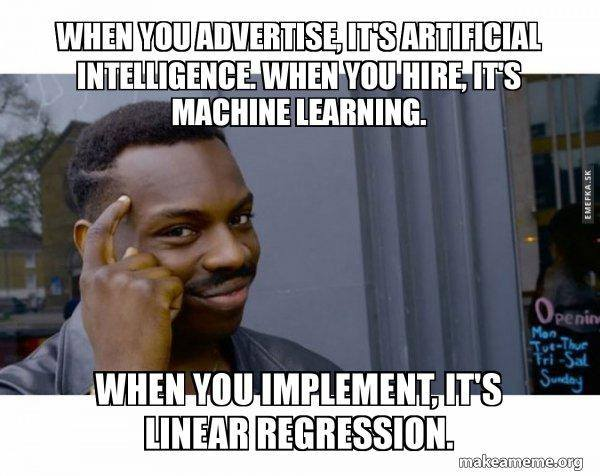